In [1]:
import os
import base64
import io
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm, t
from scipy.stats import ttest_ind
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, display
import imageio
from scipy.spatial.distance import cosine  # V2V communication: state similarity

plt.style.use('ggplot')
%matplotlib inline

In [2]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
if not path_HW5.endswith(os.sep):
    path_HW5 += os.sep

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
    os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

Using device: cpu


In [3]:
class QNetwork_Linear(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, 125), nn.ReLU(),
            nn.Linear(125, 125), nn.ReLU(),
            nn.Linear(125, action_size)
        )
    def forward(self, state):
        return self.net(state)

class QNetwork_CNN(nn.Module):
    def __init__(self, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten()
        )
        self.head = nn.Sequential(
            nn.LazyLinear(256), nn.ReLU(),
            nn.Linear(256, action_size)
        )
    def forward(self, state):
        return self.head(self.features(state))

In [4]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [5]:
class Agent:
    def __init__(self, state_size, action_size, network_type, seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(seed)
        self.network_type = network_type.lower()
        if self.network_type == 'linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BICUBIC), T.ToTensor()])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
        screen = torch.from_numpy(screen).permute(2, 0, 1)
        return self.resize(screen).unsqueeze(0)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(self.memory.sample())

    def act(self, state, eps=0.0):
        if self.network_type == 'linear':
            state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state_t = state.to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_t)
        self.qnetwork_local.train()
        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy()))
        return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        with torch.no_grad():
            q_targets_next = self.qnetwork_target(next_states).max(1, keepdim=True)[0]
            q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        with torch.no_grad():
            for tp, lp in zip(target_model.parameters(), local_model.parameters()):
                tp.data.copy_(tau * lp.data + (1 - tau) * lp.data)

In [6]:
#cell 6
class DQN:
    def __init__(self, env, env_name, model_path, data_path, network_type,
                 env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env.unwrapped
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type.lower()
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.policy_freq = int(self.env.config.get('policy_frequency', 10))
        self.obs_cfg = dict(self.env.config.get('observation', {}))

    def _make_eval_env(self, name_prefix=None):
        env = gym.make(self.env_name, render_mode='rgb_array')
        cfg = {"policy_frequency": self.policy_freq, "observation": self.obs_cfg}
        if hasattr(env, "configure"):
            env.configure(cfg)
        else:
            env.unwrapped.config.update(cfg)
        env.reset()
        if name_prefix:
            videos_dir = os.path.join(path_HW5, "Videos")
            env = RecordVideo(env, video_folder=videos_dir,
                              name_prefix=name_prefix, episode_trigger=lambda ep: True)
        return env

    def train_with_state(self, n_iteration, n_training_episodes, max_step,
                         eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with state for {self.env_name}...")
        if n_iteration[0] != 1:
            prev = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev):
                self.df_reward = pd.read_excel(prev)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state0, _ = self.env.reset()
            state_size = int(np.prod(state0.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])

            if self.env_name_source and self.model_path_source and self.transfer_episode:
                lp = os.path.join(self.model_path_source, f'Models_Run_{iter}',
                                  f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
                tp = os.path.join(self.model_path_source, f'Models_Run_{iter}',
                                  f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
                if os.path.exists(lp) and os.path.exists(tp):
                    agent.qnetwork_local.load_state_dict(torch.load(lp, map_location=device))
                    agent.qnetwork_target.load_state_dict(torch.load(tp, map_location=device))
                else:
                    print(f"Warning: transfer checkpoints missing: {lp} or {tp}")

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in trange(1, n_training_episodes + 1, desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                state, _ = self.env.reset()
                total_reward = 0.0
                for _ in range(max_step):
                    action = agent.act(state.ravel(), eps)
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
                    if terminated or truncated:
                        break
                    state = next_state
                episodes_reward.append(total_reward)

                if episode_num % 20 == 0:
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)

                if episode_num % 100 == 0:
                    torch.save(agent.qnetwork_local.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            tmp = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(tmp):
                os.remove(tmp)
        return self.df_reward

    def train_with_observation(self, n_iteration, n_training_episodes, max_step,
                               eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with observation for {self.env_name}...")
        if self.network_type != "cnn":
            raise ValueError("Use network_type='cnn' for observation training")

        if n_iteration[0] != 1:
            prev = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev):
                self.df_reward = pd.read_excel(prev)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in trange(1, n_training_episodes + 1, desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                self.env.reset()
                last_screen = agent.get_screen(self.env.render())
                current_screen = agent.get_screen(self.env.render())
                obs = current_screen - last_screen

                total_reward = 0.0
                for _ in range(max_step):
                    action = agent.act(obs, eps)
                    _, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    last_screen = current_screen
                    current_screen = agent.get_screen(self.env.render())
                    nxt = current_screen - last_screen
                    agent.step(obs.cpu().numpy(), action, reward, nxt.cpu().numpy(), terminated or truncated)
                    if terminated or truncated:
                        break
                    obs = nxt
                episodes_reward.append(total_reward)

                if episode_num % 20 == 0:
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)

                if episode_num % 100 == 0:
                    torch.save(agent.qnetwork_local.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(),
                               os.path.join(self.model_path, f'Models_Run_{iter}',
                                            f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            tmp = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(tmp):
                os.remove(tmp)
        return self.df_reward

    def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num,
                   use_saved_model=True, num_episodes=3, max_eval_steps=5000):
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)

        s0, _ = self.env.reset()
        state_size = int(np.prod(s0.shape))
        action_size = self.env.action_space.n
        agent = Agent(state_size, action_size, self.network_type, seed=11)

        if use_saved_model:
            local_name = f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth'
            target_name = f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth'
            lp = os.path.join(self.model_path, f'Models_Run_{iter_num}', local_name)
            tp = os.path.join(self.model_path, f'Models_Run_{iter_num}', target_name)
            if os.path.exists(lp) and os.path.exists(tp):
                agent.qnetwork_local.load_state_dict(torch.load(lp, map_location=device))
                agent.qnetwork_target.load_state_dict(torch.load(tp, map_location=device))
            else:
                print(f"Error: model files not found:\n{lp}\n{tp}")
                return None, 0

        eval_rewards = []
        crashes = 0
        for ep in range(num_episodes):
            env_eval = self._make_eval_env(name_prefix=f"{self.env_name}_eval_ep{ep}")
            if evaluate_type == 'state':
                state, _ = env_eval.reset()
                done, steps, ep_r = False, 0, 0.0
                while not done and steps < max_eval_steps:
                    action = agent.act(state.ravel(), eps=0.0)
                    state, reward, term, trunc, info = env_eval.step(action)
                    ep_r += reward
                    if isinstance(info, dict) and info.get('crashed', False):
                        crashes += 1
                    done = bool(term or trunc)
                    steps += 1
            else:
                env_eval.reset()
                last = agent.get_screen(env_eval.render())
                cur = agent.get_screen(env_eval.render())
                obs = cur - last
                done, steps, ep_r = False, 0, 0.0
                while not done and steps < max_eval_steps:
                    action = agent.act(obs, eps=0.0)
                    _, reward, term, trunc, info = env_eval.step(action)
                    if isinstance(info, dict) and info.get('crashed', False):
                        crashes += 1
                    last = cur
                    cur = agent.get_screen(env_eval.render())
                    obs = cur - last
                    ep_r += reward
                    done = bool(term or trunc)
                    steps += 1
            env_eval.close()
            eval_rewards.append(ep_r)

        avg_reward = float(np.mean(eval_rewards)) if eval_rewards else 0.0
        crash_rate = crashes / max(1, num_episodes)
        print(f"Eval avg reward: {avg_reward:.2f} | crash rate: {crash_rate:.2%}")
        return avg_reward, crash_rate

In [7]:
#cell 8
class show_and_plot:
    def __init__(self): pass

    def show_video(self, directory, file_or_prefix):
        directory = directory if directory.endswith(os.sep) else directory + os.sep
        exact = os.path.join(directory, file_or_prefix)
        if os.path.exists(exact):
            mp4 = exact
        else:
            candidates = sorted(glob.glob(os.path.join(directory, f"{file_or_prefix}*.mp4")))
            if not candidates:
                any_mp4 = sorted(glob.glob(os.path.join(directory, "*.mp4")))
                print("Available videos:", [os.path.basename(x) for x in any_mp4])
                print(f"Not found: {exact}")
                return
            mp4 = candidates[-1]
        print(f"Displaying: {mp4}")
        with open(mp4, 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('ascii')
        display(HTML(f'''
        <video alt="eval" autoplay loop controls style="height: 220px; width: 860px;">
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
        '''))

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1)
                         for i in range(int((n_episode - window)/stride) + 1)]
        smooth_reward = np.array(smooth_reward).T
        X = range(1, len(smooth_reward[0])*stride + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(max(1, n_iter))
        interval = 1 - alpha
        stat = t.interval(interval, df=max(1, n_iter-1))[1] if n_iter < 30 else norm.interval(interval)[1]
        ME = stat * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Average Reward")
        ax.set_title(f"{title}\nwindow={window}, stride={stride}")
        return ax

Visualizing highway-v0 environment...
Frame shape: (150, 600, 3)


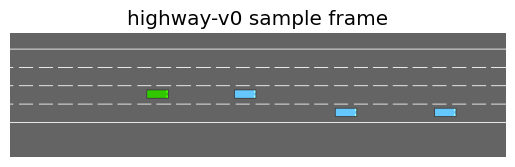

In [8]:
# cell 9
print("Visualizing highway-v0 environment...")
env = gym.make('highway-v0', render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    env.unwrapped.config.update(cfg)
obs, _ = env.reset()
frame = env.render()
print("Frame shape:", None if frame is None else frame.shape)
if frame is not None and np.mean(frame) > 0:
    img_path = os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png')
    imageio.imwrite(img_path, frame)
    plt.imshow(frame); plt.title("highway-v0 sample frame"); plt.axis('off'); plt.show()
env.close()

[Merge-v0] obs shape: (5, 5), action size: 5
Training Merge-v0...
Training agent with state for merge-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove


Iter 1 Episodes:   6%|▌         | 11/200 [00:15<05:01,  1.59s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
over

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue


Iter 1 Episodes:  30%|███       | 60/200 [01:21<03:22,  1.45s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  40%|████      | 81/200 [01:53<02:32,  1.28s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  52%|█████▎    | 105/200 [02:37<03:02,  1.92s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  66%|██████▋   | 133/200 [03:36<02:19,  2.08s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  86%|████████▋ | 173/200 [05:07<01:00,  2.24s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  94%|█████████▎| 187/200 [05:38<00:25,  1.99s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse


Iter 1 Episodes:  97%|█████████▋| 194/200 [05:52<00:11,  1.94s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

Iterations: 100%|██████████| 1/1 [06:05<00:00, 365.77s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Training completed in 6.10 min


Total episodes: 200
Reward mean (all): 157.99, std: 48.83, min: 55.68, max: 224.68, median: 163.92
Reward mean (last 50): 187.64


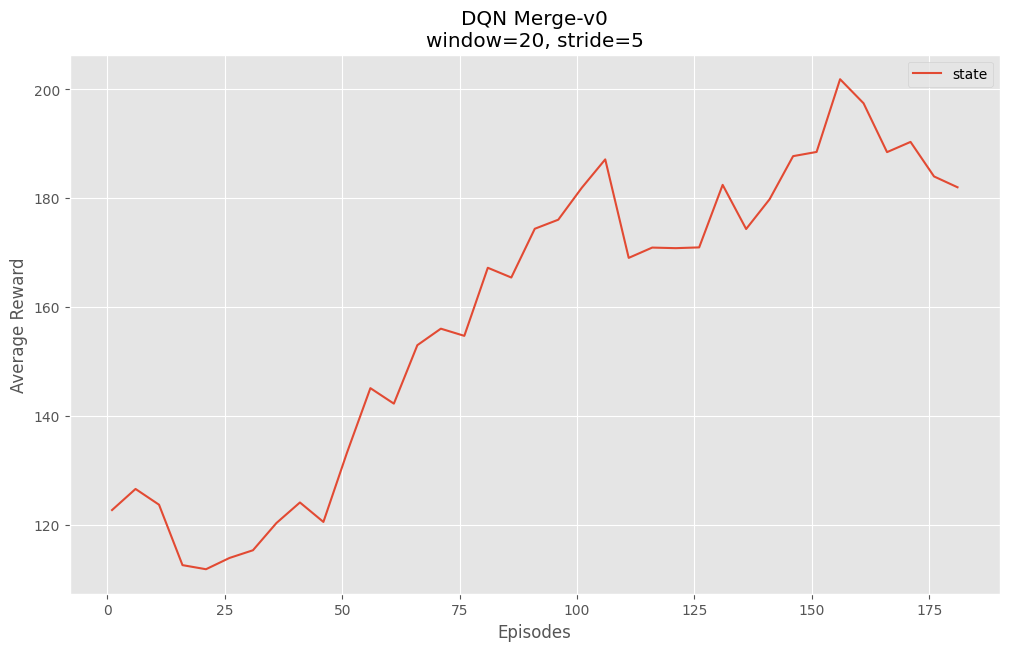

Evaluating Merge-v0 with video...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse


Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 204.42 | crash rate: 0.00%
[Eval] Avg reward: 204.42 | Crash rate: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

In [9]:
# cell 10 Part 2 – Merge-v0 (single-agent, state)

import time
from statistics import mean, median

video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
env_name = 'merge-v0'

# Build and configure env
env = gym.make(env_name, render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    env.unwrapped.config.update(cfg)
obs0, _ = env.reset()
print(f"[Merge-v0] obs shape: {obs0.shape}, action size: {env.action_space.n}")

# Trainer
dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# Train
episodes = 200       # increase for stronger results (e.g., 1000+)
max_step = 1500
t0 = time.time()
print("Training Merge-v0...")
df_reward_merge = dqn_merge.train_with_state(n_iteration=[1], n_training_episodes=episodes, max_step=max_step)
t1 = time.time()
print(f"Training completed in {(t1 - t0)/60:.2f} min")

# Save and show training stats
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    rewards = df_merge['Run_1'].dropna().to_numpy().tolist()
    print(f"Total episodes: {len(rewards)}")
    print(f"Reward mean (all): {mean(rewards):.2f}, std: {np.std(rewards):.2f}, min: {np.min(rewards):.2f}, max: {np.max(rewards):.2f}, median: {median(rewards):.2f}")
    last_n = min(50, len(rewards))
    print(f"Reward mean (last {last_n}): {mean(rewards[-last_n:]):.2f}")
except Exception as e:
    print("Training metrics read failed:", e)

# Plot training curve (rolling mean with CI)
try:
    df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_1.xlsx'))
    ep_merge = df_merge.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge-v0', 'state', window=20, stride=5)
    plt.legend(); plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)
except Exception as e:
    print("Plotting failed:", e)

# Evaluate with video (uses saved model at 'episodes')
print("Evaluating Merge-v0 with video...")
avg_reward, crash_rate = dqn_merge.evaluation(
    video_file=os.path.join(video_path, "merge.mp4"),
    evaluate_type='state',
    iter_num=1,
    evaluate_episode_num=episodes,
    use_saved_model=True,
    num_episodes=2,
    max_eval_steps=3000
)
print(f"[Eval] Avg reward: {avg_reward:.2f} | Crash rate: {crash_rate:.2%}")
show_and_plot().show_video(video_path, "merge-v0_eval_ep")

# Extra evaluation metrics (no video, 20 eps)
def collect_eval_metrics(dqn, checkpoint_episode=episodes, episodes_eval=20, max_steps=3000):
    env_eval = dqn._make_eval_env(name_prefix=None)
    s0, _ = env_eval.reset()
    state_size = int(np.prod(s0.shape))
    action_size = env_eval.action_space.n
    ag = Agent(state_size, action_size, dqn.network_type, seed=99)
    local = os.path.join(dqn.model_path, f"Models_Run_1", f"checkpoint_dqn_state_{dqn.env_name}_local_{checkpoint_episode}.pth")
    target = os.path.join(dqn.model_path, f"Models_Run_1", f"checkpoint_dqn_state_{dqn.env_name}_target_{checkpoint_episode}.pth")
    ag.qnetwork_local.load_state_dict(torch.load(local, map_location=device))
    ag.qnetwork_target.load_state_dict(torch.load(target, map_location=device))
    ep_rewards, ep_steps, crashes = [], [], 0
    for _ in range(episodes_eval):
        s, _ = env_eval.reset()
        done, steps, ep_r = False, 0, 0.0
        while not done and steps < max_steps:
            a = ag.act(s.ravel(), eps=0.0)
            s, r, term, trunc, info = env_eval.step(a)
            ep_r += r
            if isinstance(info, dict) and info.get("crashed", False):
                crashes += 1
            done = bool(term or trunc)
            steps += 1
        ep_rewards.append(ep_r)
        ep_steps.append(steps)
    env_eval.close()
    return {
        "episodes": episodes_eval,
        "reward_mean": float(np.mean(ep_rewards)),
        "reward_std": float(np.std(ep_rewards)),
        "reward_min": float(np.min(ep_rewards)),
        "reward_max": float(np.max(ep_rewards)),
        "reward_median": float(np.median(ep_rewards)),
        "steps_mean": float(np.mean(ep_steps)),
        "steps_std": float(np.std(ep_steps)),
        "crash_rate": crashes / max(1, episodes_eval)
    }

metrics = collect_eval_metrics(dqn_merge, checkpoint_episode=episodes, episodes_eval=20, max_steps=3000)
print("[Extra Eval Metrics]")
for k, v in metrics.items():
    print(f"  - {k}: {v}")

[Fast] obs shape: (5, 5), action size: 5
Training highway-fast-v0...
Training agent with state for highway-fast-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations: 100%|██████████| 1/1 [03:56<00:00, 236.39s/it]


Training completed in 3.94 min
Total episodes: 200
Reward mean (all): 58.37, std: 42.70, min: 8.00, max: 139.49, median: 43.59
Reward mean (last 50): 86.67


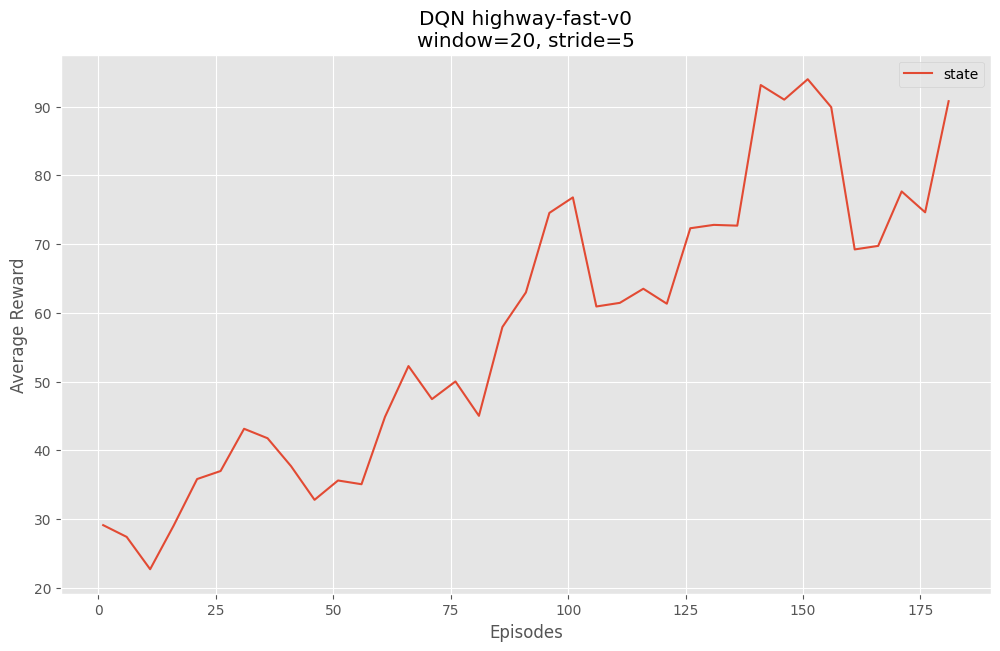

Evaluating highway-fast-v0 with video...
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 103.44 | crash rate: 0.00%
[Eval] Avg reward: 103.44 | Crash rate: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


[Extra Eval Metrics - Fast]
  - episodes: 20
  - reward_mean: 91.77448357068529
  - reward_std: 27.12059946521919
  - reward_min: 21.41399176954733
  - reward_max: 104.78930861097547
  - reward_median: 102.48302921995418
  - steps_mean: 133.85
  - steps_std: 41.04177749562024
  - crash_rate: 0.15


In [10]:
#cell 11 Part 3 – highway-fast-v0 (single-agent, state)

import time
from statistics import mean, median

video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
env_name = 'highway-fast-v0'

env = gym.make(env_name, render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5,
    "collision_reward": -10.0,
    "high_speed_reward": 1.0,
    "reward_speed_range": [20, 30]
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    env.unwrapped.config.update(cfg)
obs0, _ = env.reset()
print(f"[Fast] obs shape: {obs0.shape}, action size: {env.action_space.n}")

dqn_fast = DQN(env, env_name, model_path, data_path_2, 'linear')

episodes = 200
max_step = 1500
t0 = time.time()
print("Training highway-fast-v0...")
df_reward_fast = dqn_fast.train_with_state(n_iteration=[1], n_training_episodes=episodes, max_step=max_step)
t1 = time.time()
print(f"Training completed in {(t1 - t0)/60:.2f} min")

# Training summary
try:
    df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_1.xlsx'))
    rewards = df_fast['Run_1'].dropna().to_numpy().tolist()
    print(f"Total episodes: {len(rewards)}")
    print(f"Reward mean (all): {mean(rewards):.2f}, std: {np.std(rewards):.2f}, min: {np.min(rewards):.2f}, max: {np.max(rewards):.2f}, median: {median(rewards):.2f}")
    last_n = min(50, len(rewards))
    print(f"Reward mean (last {last_n}): {mean(rewards[-last_n:]):.2f}")
except Exception as e:
    print("Training metrics read failed:", e)

# Plot training curve
try:
    df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_1.xlsx'))
    ep_fast = df_fast.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = show_and_plot().plot_training_result(ep_fast, ax, 'DQN highway-fast-v0', 'state', window=20, stride=5)
    plt.legend(); plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images/2-fastHighway-state.png'), dpi=300)
except Exception as e:
    print("Plotting failed:", e)

# Eval with video
print("Evaluating highway-fast-v0 with video...")
avg_reward, crash_rate = dqn_fast.evaluation(
    video_file=os.path.join(video_path, "fastHighway.mp4"),
    evaluate_type='state',
    iter_num=1,
    evaluate_episode_num=episodes,
    use_saved_model=True,
    num_episodes=2,
    max_eval_steps=3000
)
print(f"[Eval] Avg reward: {avg_reward:.2f} | Crash rate: {crash_rate:.2%}")
show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep")

# Extra metrics
metrics = collect_eval_metrics(dqn_fast, checkpoint_episode=episodes, episodes_eval=20, max_steps=3000)
print("[Extra Eval Metrics - Fast]")
for k, v in metrics.items():
    print(f"  - {k}: {v}")

Source local exists: True len: 219
Source target exists: True len: 220
Will save to: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models\fast_t\Models_Run_1
Run dir length: 167
Training transfer (merge -> highway-fast-v0)...
Training agent with state for highway-fast-v0...


Iterations: 100%|██████████| 1/1 [05:00<00:00, 300.71s/it]


Training completed in 5.01 min
Saved checkpoints: ['checkpoint_dqn_state_highway-fast-v0_local_100.pth', 'checkpoint_dqn_state_highway-fast-v0_local_200.pth', 'checkpoint_dqn_state_highway-fast-v0_target_100.pth', 'checkpoint_dqn_state_highway-fast-v0_target_200.pth']
Total episodes: 200
Reward mean (all): 52.19, std: 33.84, min: 8.84, max: 114.71, median: 43.60
Reward mean (last 50): 66.46


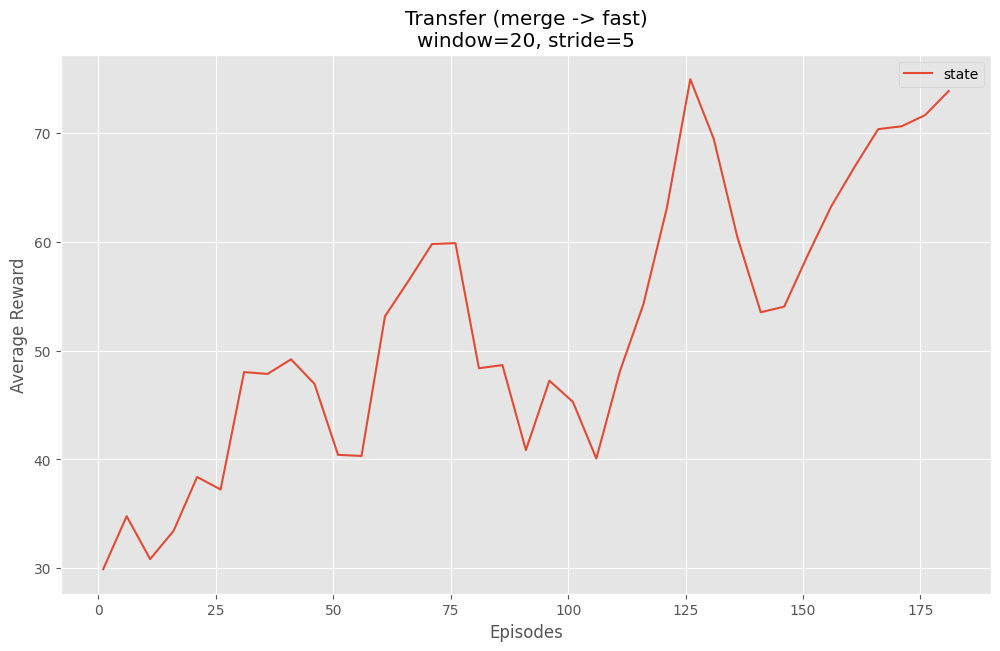

Evaluating transferred model with video...
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 107.44 | crash rate: 0.00%
[Eval] Avg reward: 107.44 | Crash rate: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


[Extra Eval Metrics - Transfer]
  - episodes: 20
  - reward_mean: 104.64332267432648
  - reward_std: 19.017473886353393
  - reward_min: 22.266664580628646
  - reward_max: 111.21648977878573
  - reward_median: 109.0812728142667
  - steps_mean: 145.0
  - steps_std: 26.153393661244042
  - crash_rate: 0.05


In [11]:
# Part 3 – Transfer learning: merge -> highway-fast-v0 (Windows-safe paths)

import time
from statistics import mean, median

video_path = os.path.join(path_HW5, 'Videos')

# SHORTER DEST PATHS to avoid Windows 260-char limit
model_path_source = os.path.join(path_HW5, 'Models', '1_Models_merge')
model_path_dest   = os.path.join(path_HW5, 'Models', 'fast_t')            # shortened
data_path_3       = os.path.join(path_HW5, 'Data_Average_Reward', 'fast_t')  # shortened
os.makedirs(model_path_dest, exist_ok=True)
os.makedirs(data_path_3, exist_ok=True)

env_name_source = 'merge-v0'
env_name = 'highway-fast-v0'

# Build target env (same obs/policy config as fast training)
env = gym.make(env_name, render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    env.unwrapped.config.update(cfg)
env.reset()

# Confirm source checkpoints exist (from Cell 10 training with 200 episodes)
src_local = os.path.join(model_path_source, 'Models_Run_1', f'checkpoint_dqn_state_{env_name_source}_local_200.pth')
src_target = os.path.join(model_path_source, 'Models_Run_1', f'checkpoint_dqn_state_{env_name_source}_target_200.pth')
print("Source local exists:", os.path.exists(src_local), "len:", len(str(src_local)))
print("Source target exists:", os.path.exists(src_target), "len:", len(str(src_target)))
if not (os.path.exists(src_local) and os.path.exists(src_target)):
    raise FileNotFoundError("Source merge checkpoints not found. Train Merge-v0 first (Cell 10) for 200 episodes.")

# Trainer with shorter destination
dqn_transfer = DQN(
    env, env_name,
    model_path_dest,  # shortened path
    data_path_3,      # shortened path
    'linear',
    env_name_source=env_name_source,
    model_path_source=model_path_source,
    transfer_episode=200
)

episodes = 200
max_step = 1500

# Print where we'll save to, and check path lengths
run_dir = os.path.join(model_path_dest, 'Models_Run_1')
print("Will save to:", run_dir)
print("Run dir length:", len(str(run_dir)))
os.makedirs(run_dir, exist_ok=True)

t0 = time.time()
print("Training transfer (merge -> highway-fast-v0)...")
df_reward_transfer = dqn_transfer.train_with_state(
    n_iteration=[1],
    n_training_episodes=episodes,
    max_step=max_step
)
t1 = time.time()
print(f"Training completed in {(t1 - t0)/60:.2f} min")

# List saved checkpoints to confirm
ckpts = sorted(glob.glob(os.path.join(run_dir, "*.pth")))
print("Saved checkpoints:", [os.path.basename(p) for p in ckpts[-6:]])  # tail

# Training summary
try:
    df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_1.xlsx'))
    rewards = df_trans['Run_1'].dropna().to_numpy().tolist()
    print(f"Total episodes: {len(rewards)}")
    print(f"Reward mean (all): {mean(rewards):.2f}, std: {np.std(rewards):.2f}, min: {np.min(rewards):.2f}, max: {np.max(rewards):.2f}, median: {median(rewards):.2f}")
    last_n = min(50, len(rewards))
    print(f"Reward mean (last {last_n}): {mean(rewards[-last_n:]):.2f}")
except Exception as e:
    print("Training metrics read failed:", e)

# Plot training curve
try:
    df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_1.xlsx'))
    ep_trans = df_trans.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = show_and_plot().plot_training_result(ep_trans, ax, 'Transfer (merge -> fast)', 'state', window=20, stride=5)
    plt.legend(); plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images', '3-fastHighway-transfer-state.png'), dpi=300)
except Exception as e:
    print("Plotting failed:", e)

# Eval with video (prefix-based display)
print("Evaluating transferred model with video...")
avg_reward, crash_rate = dqn_transfer.evaluation(
    video_file=os.path.join(video_path, "fastHighway_transferred_from_merge.mp4"),
    evaluate_type='state',
    iter_num=1,
    evaluate_episode_num=episodes,
    use_saved_model=True,
    num_episodes=2,
    max_eval_steps=3000
)
print(f"[Eval] Avg reward: {avg_reward:.2f} | Crash rate: {crash_rate:.2%}")
show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep")

# Extra metrics
metrics = collect_eval_metrics(dqn_transfer, checkpoint_episode=episodes, episodes_eval=20, max_steps=3000)
print("[Extra Eval Metrics - Transfer]")
for k, v in metrics.items():
    print(f"  - {k}: {v}")

[CNN] obs shape: (5, 5), action size: 5
Cleared 2 old checkpoints in C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models\4a_CNN_merge\Models_Run_1
Training merge-v0 (CNN/observation)...
Training agent with observation for merge-v0...


Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse


Iterations: 100%|██████████| 1/1 [18:30<00:00, 1110.74s/it]


Training completed in 18.51 min
Total episodes: 100
Reward mean (all): 109.99, std: 33.61, min: 61.25, max: 190.79, median: 107.26
Reward mean (last 20): 113.54


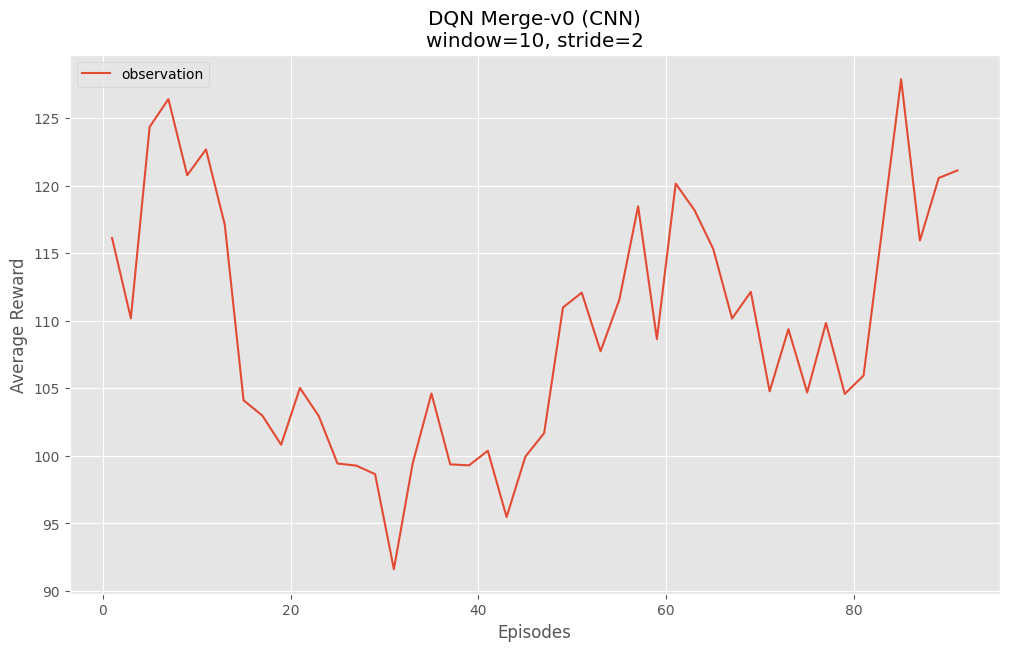

Using latest CNN checkpoint episode: 100
Evaluating merge-v0 (CNN/observation) with video...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 103.27 | crash rate: 100.00%
[Eval] Avg reward: 103.27 | Crash rate: 100.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

In [12]:
# Part 4 – Merge-v0 with CNN and observation (fresh dir, guaranteed checkpoint, robust eval)

import os, re, glob, time
from statistics import mean, median

video_path = os.path.join(path_HW5, 'Videos')

# Use a fresh, shorter path to avoid stale checkpoints and Windows path issues
model_path = os.path.join(path_HW5, 'Models', '4a_CNN_merge')
data_path_4 = os.path.join(path_HW5, 'Data_Average_Reward', '4a_Data_CNN_merge')
env_name = 'merge-v0'

os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path_4, exist_ok=True)

# Build env and configure
env = gym.make(env_name, render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10
}
if hasattr(env, "configure"):
    env.configure(cfg)
else:
    env.unwrapped.config.update(cfg)
obs0, _ = env.reset()
print(f"[CNN] obs shape: {obs0.shape}, action size: {env.action_space.n}")

# Clean previous checkpoints in this run dir to avoid loading old architecture
run_dir = os.path.join(model_path, 'Models_Run_1')
os.makedirs(run_dir, exist_ok=True)
old_ckpts = glob.glob(os.path.join(run_dir, "*.pth"))
for p in old_ckpts:
    try:
        os.remove(p)
    except Exception:
        pass
print(f"Cleared {len(old_ckpts)} old checkpoints in {run_dir}")

# Trainer
dqn_merge_cnn = DQN(env, env_name, model_path, data_path_4, 'cnn')

# Train: set to 100 so a checkpoint is saved by the internal schedule
episodes = 100
max_step = 1500
t0 = time.time()
print("Training merge-v0 (CNN/observation)...")
df_reward_merge_cnn = dqn_merge_cnn.train_with_observation(
    n_iteration=[1],
    n_training_episodes=episodes,
    max_step=max_step
)
t1 = time.time()
print(f"Training completed in {(t1 - t0)/60:.2f} min")

# Training summary
try:
    df_cnn = pd.read_excel(os.path.join(data_path_4, 'Episodes_reward_run_1.xlsx'))
    rewards = df_cnn['Run_1'].dropna().to_numpy().tolist()
    print(f"Total episodes: {len(rewards)}")
    print(f"Reward mean (all): {mean(rewards):.2f}, std: {np.std(rewards):.2f}, "
          f"min: {np.min(rewards):.2f}, max: {np.max(rewards):.2f}, median: {median(rewards):.2f}")
    last_n = min(20, len(rewards))
    print(f"Reward mean (last {last_n}): {mean(rewards[-last_n:]):.2f}")
except Exception as e:
    print("Training metrics read failed:", e)

# Plot training curve
try:
    df_cnn = pd.read_excel(os.path.join(data_path_4, 'Episodes_reward_run_1.xlsx'))
    ep_cnn = df_cnn.T.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = show_and_plot().plot_training_result(ep_cnn, ax, 'DQN Merge-v0 (CNN)', 'observation', window=10, stride=2)
    plt.legend(); plt.show()
    fig.savefig(os.path.join(path_HW5, 'Images', '4-merge-v0-cnn-observation.png'), dpi=300)
except Exception as e:
    print("Plotting failed:", e)

# Find the latest saved CNN checkpoint (local) for evaluation
pattern = os.path.join(run_dir, f'checkpoint_dqn_observation_{env_name}_local_*.pth')
candidates = glob.glob(pattern)
if not candidates:
    raise FileNotFoundError("No CNN checkpoints found. Ensure 'episodes' is a multiple of the save interval (100).")
def extract_ep(path):
    m = re.search(r'_local_(\d+)\.pth$', os.path.basename(path))
    return int(m.group(1)) if m else -1
latest_local = max(candidates, key=extract_ep)
latest_ep = extract_ep(latest_local)
print(f"Using latest CNN checkpoint episode: {latest_ep}")

# Eval with video using the latest available checkpoint
print("Evaluating merge-v0 (CNN/observation) with video...")
avg_reward, crash_rate = dqn_merge_cnn.evaluation(
    video_file=os.path.join(video_path, "merge_observation_CNN.mp4"),
    evaluate_type='observation',
    iter_num=1,
    evaluate_episode_num=latest_ep,  # use detected latest
    use_saved_model=True,
    num_episodes=2,
    max_eval_steps=3000
)
print(f"[Eval] Avg reward: {avg_reward:.2f} | Crash rate: {crash_rate:.2%}")
show_and_plot().show_video(video_path, "merge-v0_eval_ep")

# Extra metrics (no video) for CNN path with the same latest checkpoint
def collect_eval_metrics_obs(dqn, checkpoint_episode, episodes_eval=10, max_steps=3000):
    env_eval = dqn._make_eval_env(name_prefix=None)
    s0, _ = env_eval.reset()
    state_size = int(np.prod(s0.shape))
    action_size = env_eval.action_space.n
    ag = Agent(state_size, action_size, dqn.network_type, seed=101)
    local = os.path.join(dqn.model_path, "Models_Run_1",
                         f"checkpoint_dqn_observation_{dqn.env_name}_local_{checkpoint_episode}.pth")
    target = os.path.join(dqn.model_path, "Models_Run_1",
                          f"checkpoint_dqn_observation_{dqn.env_name}_target_{checkpoint_episode}.pth")
    ag.qnetwork_local.load_state_dict(torch.load(local, map_location=device))
    ag.qnetwork_target.load_state_dict(torch.load(target, map_location=device))
    ep_rewards, ep_steps, crashes = [], [], 0
    for _ in range(episodes_eval):
        env_eval.reset()
        last = ag.get_screen(env_eval.render())
        cur = ag.get_screen(env_eval.render())
        obs = cur - last
        done, steps, ep_r = False, 0, 0.0
        while not done and steps < max_steps:
            a = ag.act(obs, eps=0.0)
            _, r, term, trunc, info = env_eval.step(a)
            if isinstance(info, dict) and info.get("crashed", False):
                crashes += 1
            last = cur
            cur = ag.get_screen(env_eval.render())
            obs = cur - last
            ep_r += r
            done = bool(term or trunc)
            steps += 1
        ep_rewards.append(ep_r)
        ep_steps.append(steps)
    env_eval.close()
    return {
        "episodes": episodes_eval,
        "reward_mean": float(np.mean(ep_rewards)),
        "reward_std": float(np.std(ep_rewards)),
        "reward_min": float(np.min(ep_rewards)),
        "reward_max": float(np.max(ep_rewards)),
        "reward_median": float(np.median(ep_rewards)),
        "steps_mean": float(np.mean(ep_steps)),
        "steps_std": float(np.std(ep_steps)),
        "crash_rate": crashes / max(1, episodes_eval)
    }

metrics_cnn = collect_eval_metrics_obs(dqn_merge_cnn, checkpoint_episode=latest_ep, episodes_eval=10, max_steps=3000)
print("[Extra Eval Metrics - CNN/Observation]")
for k, v in metrics_cnn.items():
    print(f"  - {k}: {v}")

,scenario,episodes,reward_mean,reward_std,reward_min,reward_max,reward_median,last_20_mean
0,fast_state,200,58.374537,42.700528,7.998653,139.493455,43.587610,90.772007
1,merge_cnn,100,109.990454,33.605047,61.246803,190.785363,107.258775,113.535043
2,merge_state,200,157.993631,48.825798,55.682200,224.684264,163.923767,182.008934
3,transfer,200,52.187054,33.843045,8.842009,114.708828,43.602148,73.893966


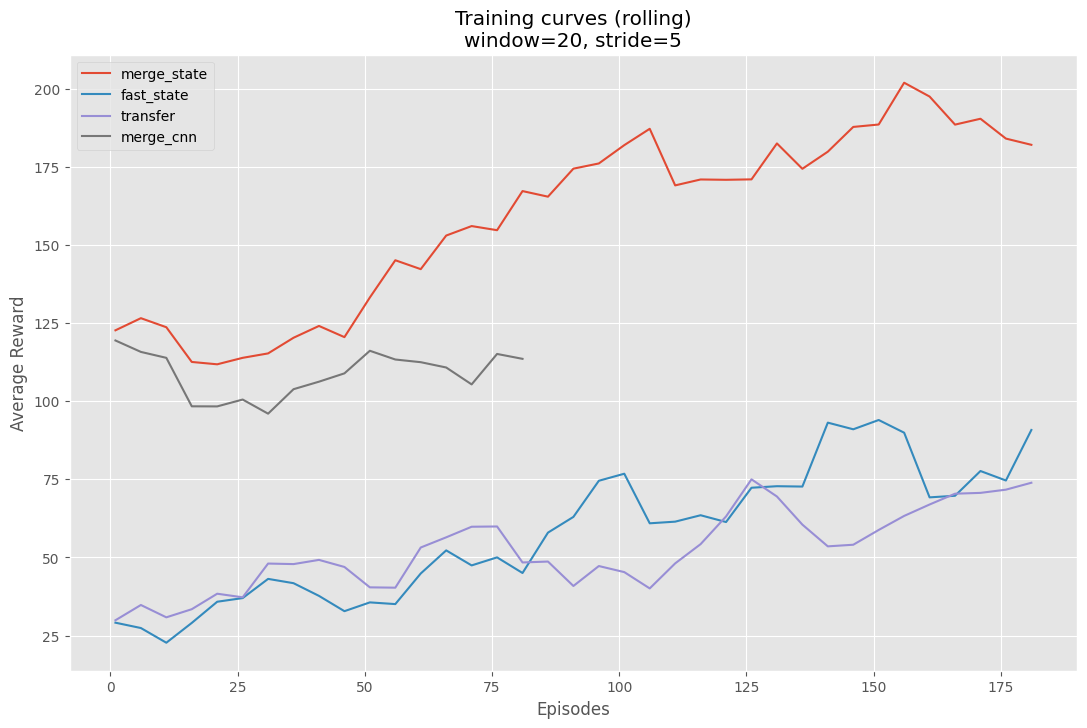

In [13]:
# Part 5 – Comparison plots and summary table

from statistics import mean, median

def load_rewards_xlsx(path):
    try:
        df = pd.read_excel(path)
        return df['Run_1'].dropna().to_numpy().tolist()
    except Exception as e:
        print("Failed to load:", path, e)
        return None

# Paths
merge_xlsx = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx')
fast_xlsx  = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx')
tran_xlsx  = os.path.join(path_HW5, 'Data_Average_Reward/fast_t', 'Episodes_reward_run_1.xlsx')  # shortened path used in Cell 12
cnn_xlsx   = os.path.join(path_HW5, 'Data_Average_Reward/4a_Data_CNN_merge', 'Episodes_reward_run_1.xlsx')

data = {
    'merge_state': load_rewards_xlsx(merge_xlsx),
    'fast_state':  load_rewards_xlsx(fast_xlsx),
    'transfer':    load_rewards_xlsx(tran_xlsx),
    'merge_cnn':   load_rewards_xlsx(cnn_xlsx),
}

# Summary table
rows = []
for name, rewards in data.items():
    if not rewards:
        continue
    rows.append({
        'scenario': name,
        'episodes': len(rewards),
        'reward_mean': float(np.mean(rewards)),
        'reward_std': float(np.std(rewards)),
        'reward_min': float(np.min(rewards)),
        'reward_max': float(np.max(rewards)),
        'reward_median': float(np.median(rewards)),
        'last_20_mean': float(np.mean(rewards[-min(20, len(rewards)):])),
    })
summary_df = pd.DataFrame(rows).sort_values('scenario').reset_index(drop=True)
display(summary_df)

# Plot rolling curves side-by-side (if available)
fig, ax = plt.subplots(figsize=(13, 8))
def plot_from_xlsx(xlsx_path, label, color=None):
    try:
        df = pd.read_excel(xlsx_path)
        arr = df.T.to_numpy()
        # reuse plotting helper from earlier cell
        ax2 = show_and_plot().plot_training_result(arr, ax, title='Training curves (rolling)', label=label, window=20, stride=5, alpha=0.2)
    except Exception as e:
        print("Skip plot for", label, "->", e)

plot_from_xlsx(merge_xlsx, 'merge_state')
plot_from_xlsx(fast_xlsx,  'fast_state')
plot_from_xlsx(tran_xlsx,  'transfer')
plot_from_xlsx(cnn_xlsx,   'merge_cnn')
plt.legend(); plt.show()
fig.savefig(os.path.join(path_HW5, 'Images', '5-comparison-rolling.png'), dpi=300)

In [14]:
# Part 6 – Create continuous videos by concatenating evaluation clips (imageio-based, no moviepy)

import sys, subprocess
from pathlib import Path

# Ensure ffmpeg backend for imageio
try:
    import imageio_ffmpeg  # noqa
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imageio-ffmpeg"])
    import imageio_ffmpeg  # noqa

import imageio
from PIL import Image
import numpy as np

def concat_eval_videos_imageio(video_dir, prefix, out_name, limit=None, target_size=None, target_fps=None):
    video_dir = Path(video_dir)
    clips = sorted(video_dir.glob(f"{prefix}*.mp4"))
    if not clips:
        print(f"No clips found for prefix '{prefix}' in {video_dir}")
        return None

    if limit:
        clips = clips[-limit:]

    # Determine target size and fps from first clip if not provided
    first_reader = imageio.get_reader(str(clips[0]), format="ffmpeg")
    meta = first_reader.get_meta_data()
    if target_fps is None:
        target_fps = int(round(meta.get("fps", 30)))
    if target_size is None:
        # Grab first frame to get size (W,H)
        try:
            first_frame = first_reader.get_next_data()
        except StopIteration:
            first_reader.close()
            print(f"First clip has no frames: {clips[0]}")
            return None
        h, w = first_frame.shape[:2]
        target_size = (w, h)
        # rewind reader by closing/reopening
    first_reader.close()

    out_path = video_dir / out_name
    writer = imageio.get_writer(str(out_path), fps=target_fps, macro_block_size=None)

    total_frames = 0
    for clip_path in clips:
        try:
            reader = imageio.get_reader(str(clip_path), format="ffmpeg")
            for frame in reader:
                fh, fw = frame.shape[:2]
                if (fw, fh) != target_size:
                    # Resize to target_size (W,H)
                    frame = np.asarray(Image.fromarray(frame).resize(target_size, Image.BILINEAR))
                writer.append_data(frame)
                total_frames += 1
            reader.close()
        except Exception as e:
            print(f"Skip clip due to error: {clip_path.name} -> {e}")

    writer.close()
    print(f"Wrote: {out_path} | frames: {total_frames} | fps: {target_fps} | size: {target_size}")
    return str(out_path)

video_dir = os.path.join(path_HW5, 'Videos')

# Merge-v0 continuous
merge_cont = concat_eval_videos_imageio(video_dir, "merge-v0_eval_ep", "merge-v0_eval_continuous.mp4", limit=10)
if merge_cont:
    show_and_plot().show_video(video_dir, "merge-v0_eval_continuous.mp4")

# Highway-fast-v0 continuous
fast_cont = concat_eval_videos_imageio(video_dir, "highway-fast-v0_eval_ep", "highway-fast-v0_eval_continuous.mp4", limit=10)
if fast_cont:
    show_and_plot().show_video(video_dir, "highway-fast-v0_eval_continuous.mp4")

# Transfer continuous (same eval prefix as fast; only run if transfer eval was done)
tran_cont = concat_eval_videos_imageio(video_dir, "highway-fast-v0_eval_ep", "fastHighway_transfer_continuous.mp4", limit=10)
if tran_cont:
    show_and_plot().show_video(video_dir, "fastHighway_transfer_continuous.mp4")

# CNN Merge-v0 continuous (same prefix as merge; only present after CNN eval)
cnn_cont = concat_eval_videos_imageio(video_dir, "merge-v0_eval_ep", "merge-v0_cnn_eval_continuous.mp4", limit=10)
if cnn_cont:
    show_and_plot().show_video(video_dir, "merge-v0_cnn_eval_continuous.mp4")

Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_continuous.mp4 | frames: 212 | fps: 20 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_continuous.mp4 | frames: 304 | fps: 10 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\fastHighway_transfer_continuous.mp4 | frames: 304 | fps: 10 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\fastHighway_transfer_continuous.mp4


Wrote: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_eval_continuous.mp4 | frames: 212 | fps: 20 | size: (600, 150)
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_cnn_eval_continuous.mp4


In [15]:
# Part 7 – Auto-select best checkpoint by trailing mean and record a fresh video

def best_episode_from_rewards(xlsx_path, tail=50):
    try:
        df = pd.read_excel(xlsx_path)
        rewards = df['Run_1'].dropna().to_numpy()
        if rewards.size == 0:
            return None
        tail = min(tail, rewards.size)
        # choose the best tail mean boundary (approx)
        best_idx = np.argmax(pd.Series(rewards).rolling(window=tail, min_periods=1).mean().to_numpy())
        # snap to nearest saved checkpoint (multiples of 100 from our trainer)
        best_ep = int(round((best_idx + 1) / 100.0) * 100)
        if best_ep < 100: best_ep = 100
        if best_ep > len(rewards): best_ep = (len(rewards) // 100) * 100
        return best_ep if best_ep >= 100 else None
    except Exception as e:
        print("Best-episode selection failed:", e)
        return None

# For merge-v0
merge_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx'))
print("merge-v0 best episode:", merge_best_ep)

if merge_best_ep:
    avg_reward, crash_rate = dqn_merge.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'merge_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=merge_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[merge best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "merge-v0_eval_ep")

# For highway-fast-v0
fast_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx'))
print("highway-fast-v0 best episode:", fast_best_ep)

if fast_best_ep:
    avg_reward, crash_rate = dqn_fast.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'fastHighway_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=fast_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[fast best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "highway-fast-v0_eval_ep")

merge-v0 best episode: 100
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFa

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 182.68 | crash rate: 50.00%
[merge best] avg reward: 182.68 | crash: 50.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


highway-fast-v0 best episode: 100
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 75.99 | crash rate: 50.00%
[fast best] avg reward: 75.99 | crash: 50.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


In [16]:
# Part 7 – Auto-select best checkpoint by trailing mean and record a fresh video

def best_episode_from_rewards(xlsx_path, tail=50):
    try:
        df = pd.read_excel(xlsx_path)
        rewards = df['Run_1'].dropna().to_numpy()
        if rewards.size == 0:
            return None
        tail = min(tail, rewards.size)
        # choose the best tail mean boundary (approx)
        best_idx = np.argmax(pd.Series(rewards).rolling(window=tail, min_periods=1).mean().to_numpy())
        # snap to nearest saved checkpoint (multiples of 100 from our trainer)
        best_ep = int(round((best_idx + 1) / 100.0) * 100)
        if best_ep < 100: best_ep = 100
        if best_ep > len(rewards): best_ep = (len(rewards) // 100) * 100
        return best_ep if best_ep >= 100 else None
    except Exception as e:
        print("Best-episode selection failed:", e)
        return None

# For merge-v0
merge_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge', 'Episodes_reward_run_1.xlsx'))
print("merge-v0 best episode:", merge_best_ep)

if merge_best_ep:
    avg_reward, crash_rate = dqn_merge.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'merge_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=merge_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[merge best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "merge-v0_eval_ep")

# For highway-fast-v0
fast_best_ep = best_episode_from_rewards(os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway', 'Episodes_reward_run_1.xlsx'))
print("highway-fast-v0 best episode:", fast_best_ep)

if fast_best_ep:
    avg_reward, crash_rate = dqn_fast.evaluation(
        video_file=os.path.join(path_HW5, 'Videos', 'fastHighway_best.mp4'),
        evaluate_type='state',
        iter_num=1,
        evaluate_episode_num=fast_best_ep,
        use_saved_model=True,
        num_episodes=2,
        max_eval_steps=3000
    )
    print(f"[fast best] avg reward: {avg_reward:.2f} | crash: {crash_rate:.2%}")
    show_and_plot().show_video(os.path.join(path_HW5, 'Videos'), "highway-fast-v0_eval_ep")

merge-v0 best episode: 100


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
cras

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Eval avg reward: 215.62 | crash rate: 0.00%
[merge best] avg reward: 215.62 | crash: 0.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4


highway-fast-v0 best episode: 100
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4
Eval avg reward: 25.66 | crash rate: 100.00%
[fast best] avg reward: 25.66 | crash: 100.00%
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep1-episode-0.mp4


In [17]:
# Part 9 – Multi-agent color wrapper (unique colors per agent)

from gymnasium import Wrapper

def _rgb(color):
    # Accept color tuples in [0..255] or [0..1]; normalize to 0..255 ints
    if max(color) <= 1.0:
        return tuple(int(round(c*255)) for c in color)
    return tuple(int(c) for c in color)

class ColorAgentsWrapper(Wrapper):
    def __init__(self, env, agent_colors):
        super().__init__(env)
        self.agent_colors = [ _rgb(c) for c in agent_colors ]

    def _apply_colors(self):
        vehicles = getattr(self.env.unwrapped, "controlled_vehicles", [])
        for i, v in enumerate(vehicles):
            try:
                v.color = self.agent_colors[i % len(self.agent_colors)]
            except Exception:
                pass  # some versions may not expose color; safe to skip

    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self._apply_colors()
        return obs

    def step(self, action):
        out = super().step(action)
        self._apply_colors()
        return out

# Color palette (distinct and bright)
AGENT_COLORS = [
    (255, 0, 0),      # red
    (0, 200, 0),      # green
    (0, 120, 255),    # blue
    (255, 165, 0),    # orange
    (160, 32, 240),   # purple
    (255, 20, 147),   # pink
]

In [19]:
# Part 10b – V2V Communication Helper Methods for MultiAgent CACC
# These methods enable Vehicle-to-Vehicle learning with similarity coefficients

def compute_v2v_similarity(state1, state2):
    """Compute state similarity [0,1] using cosine distance."""
    if state1 is None or state2 is None:
        return 0.0
    try:
        s1, s2 = state1.ravel(), state2.ravel()
        if s1.shape != s2.shape:
            return 0.0
        dist = cosine(s1, s2)
        return float(np.clip(1.0 - dist, 0.0, 1.0))
    except:
        return 0.0

def extract_gap_from_obs(obs, agent_idx):
    """Extract longitudinal gap to preceding vehicle from kinematics observation."""
    try:
        if obs is None or obs.size == 0:
            return 0.0
        obs_2d = obs.reshape(-1, 5) if obs.ndim == 1 else obs
        if agent_idx > 0 and agent_idx < len(obs_2d):
            my_x = obs_2d[agent_idx, 1] if agent_idx < len(obs_2d) else 0.0
            prev_x = obs_2d[agent_idx - 1, 1] if (agent_idx - 1) < len(obs_2d) else 0.0
            gap = prev_x - my_x
            return float(max(0.0, gap))
        return 0.0
    except:
        return 0.0

def compute_v2v_reward(obs, agent_idx, base_reward):
    """
    Compute V2V-aware reward with gap-based bonuses/penalties.
    Gap >= 5.0m: +0.5 bonus (safe distance)
    Gap < 2.0m: -0.5 penalty (collision risk)
    """
    if agent_idx == 0:
        return base_reward
    gap = extract_gap_from_obs(obs, agent_idx)
    if gap >= 5.0:
        return base_reward + 0.5
    elif gap < 2.0:
        return base_reward - 0.5
    return base_reward

def get_v2v_weighted_action(agent_idx, greedy_action, preceding_action, similarity):
    """
    Blend preceding agent's action with greedy action based on similarity.
    Similarity >= 0.85: 85% follow preceding agent
    0.4 <= Similarity < 0.85: 50% follow
    Similarity < 0.4: Use greedy action
    """
    if agent_idx == 0 or preceding_action is None:
        return greedy_action
    if similarity >= 0.85:
        return preceding_action if np.random.rand() < 0.85 else greedy_action
    elif similarity >= 0.4:
        return preceding_action if np.random.rand() < 0.50 else greedy_action
    else:
        return greedy_action

print("✓ V2V Communication helper methods loaded")

✓ V2V Communication helper methods loaded


In [31]:
# Part 10 – Multi-agent shared DQN with V2V communication (Vehicle-to-Vehicle learning)
from typing import Any, Dict, List, Tuple
from gymnasium.spaces import Dict as SpaceDict

class SharedDQNMultiTL:
    """
    Multi-agent capable shared DQN with V2V-style biasing.
    Fixes: robustly handles single-agent envs (int action) vs multi-agent envs (dict action).
    """

    def __init__(
        self,
        env,
        network_type: str,
        device: torch.device,
        seed: int = 11,
        similarity_metric: str = "cosine",
        high_sim_threshold: float = 0.85,
        mid_sim_threshold: float = 0.55,
        mentor_bias_scale: float = 2.0,
        max_mentor_copies: int = 2,
        imitation_bonus: float = 0.1,
        simplified_mode: bool = False,
        use_stacked_obs: bool = False,
        same_lane_y_threshold: float = 0.2,
        safe_gap_range: Tuple[float, float] = (0.2, 0.6),
        too_close_threshold: float = 0.1
    ):
        self.env = env
        self.device = device
        self.network_type = network_type
        self.rng = np.random.RandomState(seed)

        # V2V config
        self.similarity_metric = similarity_metric
        self.high_sim_threshold = float(high_sim_threshold)
        self.mid_sim_threshold = float(mid_sim_threshold)
        self.mentor_bias_scale = float(mentor_bias_scale)
        self.max_mentor_copies = int(max_mentor_copies)
        self.imitation_bonus = float(imitation_bonus)
        self.simplified_mode = bool(simplified_mode)
        self.use_stacked_obs = bool(use_stacked_obs)

        # Safe-gap reward shaping config
        self.same_lane_y_threshold = float(same_lane_y_threshold)
        self.safe_gap_range = tuple(safe_gap_range)
        self.too_close_threshold = float(too_close_threshold)

        # Detect multi-agent vs single-agent based on spaces
        self.is_multiagent = isinstance(self.env.action_space, SpaceDict) or isinstance(self.env.observation_space, SpaceDict)

        # Probe shapes and sizes
        obs_any, _ = self.env.reset()
        obs_dict = self._unify_obs_dict(obs_any)

        # Number of agents
        self.num_agents = len(obs_dict) if self.is_multiagent else 1

        sample_obs = np.asarray(next(iter(obs_dict.values())))
        base_state_size = int(np.prod(sample_obs.shape))
        self.state_size = base_state_size * (2 if self.use_stacked_obs else 1)

        # Infer action space size
        sp = getattr(self.env, "action_space", None)
        if isinstance(sp, SpaceDict):
            first_space = next(iter(sp.spaces.values()))
            self.action_size = first_space.n
        else:
            self.action_size = sp.n

        # Shared DQN agent (reuses Agent/QNetwork_Linear defined earlier)
        self.agent = Agent(self.state_size, self.action_size, network_type, seed)

    # ---------- Helpers ----------

    @staticmethod
    def _unify_obs_dict(obs_any) -> Dict[int, np.ndarray]:
        # Multi-agent dict -> assume 0..N-1 integer keys
        if isinstance(obs_any, dict):
            # normalize keys to int if possible
            out = {}
            for k, v in obs_any.items():
                try:
                    out[int(k)] = np.asarray(v)
                except Exception:
                    # fallback: keep original key as-is if not int-castable
                    out[k] = np.asarray(v)
            return out
        # Tuple/list of obs
        if isinstance(obs_any, (list, tuple)):
            return {i: np.asarray(obs_any[i]) for i in range(len(obs_any))}
        # Single-agent ndarray -> single "agent" 0
        if isinstance(obs_any, np.ndarray):
            return {0: obs_any}
        raise RuntimeError("Unexpected observation format")

    @staticmethod
    def _unify_to_list(x_any, n: int) -> List[Any]:
        if isinstance(x_any, dict):
            # assume keys are 0..n-1
            return [x_any[i] for i in range(n)]
        if isinstance(x_any, (list, tuple)):
            return list(x_any)
        return [x_any] * n

    @staticmethod
    def _flatten(x: np.ndarray) -> np.ndarray:
        return np.asarray(x, dtype=np.float32).ravel()

    def _stack_obs(self, cur_obs: np.ndarray, prev_obs: np.ndarray | None) -> np.ndarray:
        if not self.use_stacked_obs:
            return self._flatten(cur_obs)
        if prev_obs is None:
            zeros = np.zeros_like(cur_obs, dtype=np.float32)
            return np.concatenate([self._flatten(cur_obs), self._flatten(zeros)], axis=0)
        return np.concatenate([self._flatten(cur_obs), self._flatten(prev_obs)], axis=0)

    def _similarity_coef(self, a: np.ndarray, b: np.ndarray) -> float:
        a_f = self._flatten(a)
        b_f = self._flatten(b)
        if self.similarity_metric == "euclidean":
            denom = np.linalg.norm(a_f) + np.linalg.norm(b_f) + 1e-8
            dist = np.linalg.norm(a_f - b_f) / denom
            sim = 1.0 - float(np.clip(dist, 0.0, 1.0))
        else:
            denom = (np.linalg.norm(a_f) * np.linalg.norm(b_f)) + 1e-8
            cos = float(np.dot(a_f, b_f) / denom)
            sim = (cos + 1.0) * 0.5
        return float(np.clip(sim, 0.0, 1.0))

    def _safe_gap_reward_from_obs(self, obs: np.ndarray) -> float:
        try:
            presence = obs[:, 0]
            x = obs[:, 1]
            y = obs[:, 2]
        except Exception:
            return 0.0
        mask_same_lane_ahead = (presence > 0.5) & (x > 0) & (np.abs(y) < self.same_lane_y_threshold)
        if not np.any(mask_same_lane_ahead):
            return 0.0
        min_x_ahead = float(np.min(x[mask_same_lane_ahead]))
        if min_x_ahead < self.too_close_threshold:
            return -0.5
        safe_lo, safe_hi = self.safe_gap_range
        if safe_lo <= min_x_ahead <= safe_hi:
            return +0.5
        return 0.0

    # ---------- Action selection with V2V bias ----------

    def _act_batch_v2v(self, obs_list: List[np.ndarray], eps: float) -> Tuple[List[int], List[float], List[int]]:
        states_in: List[np.ndarray] = []
        for i in range(self.num_agents):
            prev_obs = obs_list[i - 1] if i > 0 else None
            states_in.append(self._stack_obs(obs_list[i], prev_obs))
        st = torch.from_numpy(np.stack(states_in, axis=0)).float().to(self.device)

        self.agent.qnetwork_local.eval()
        with torch.no_grad():
            q_all = self.agent.qnetwork_local(st)  # [N, action_size]
        self.agent.qnetwork_local.train()

        actions: List[int] = [0] * self.num_agents
        coefs: List[float] = [0.0] * self.num_agents
        mentor_actions: List[int] = [0] * self.num_agents

        # Agent 0
        q0 = q_all[0].cpu().numpy()
        actions[0] = int(self.rng.randint(0, self.action_size)) if (self.rng.rand() < eps) else int(np.argmax(q0))

        # Followers
        for i in range(1, self.num_agents):
            mentor_actions[i] = actions[i - 1]
            coef = self._similarity_coef(obs_list[i], obs_list[i - 1])
            coefs[i] = coef
            qi = q_all[i].clone()
            qi[mentor_actions[i]] = qi[mentor_actions[i]] + (self.mentor_bias_scale * coef)
            qi_np = qi.cpu().numpy()

            if self.simplified_mode:
                if coef >= self.high_sim_threshold and (self.rng.rand() > eps):
                    actions[i] = int(mentor_actions[i])
                else:
                    actions[i] = int(self.rng.randint(0, self.action_size) if self.rng.rand() < eps else np.argmax(qi_np))
            else:
                if self.rng.rand() < eps:
                    actions[i] = int(self.rng.randint(0, self.action_size))
                else:
                    if coef >= self.high_sim_threshold:
                        actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.9) else int(np.argmax(qi_np))
                    elif coef >= self.mid_sim_threshold:
                        actions[i] = int(mentor_actions[i]) if (self.rng.rand() < 0.6) else int(np.argmax(qi_np))
                    else:
                        actions[i] = int(np.argmax(qi_np))

        return actions, coefs, mentor_actions

    # ---------- Transfer loading ----------

    def load_transfer_weights(self, checkpoint_path: str) -> None:
        sd = torch.load(checkpoint_path, map_location=self.device)
        missing, unexpected = self.agent.qnetwork_local.load_state_dict(sd, strict=False)
        print("Transfer load missing:", missing, "unexpected:", unexpected)

    # ---------- Training loop ----------

    def train(
        self,
        runs: List[int],
        episodes_per_run: int,
        max_steps: int,
        out_models: str,
        out_data: str,
        save_every: int = 100,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        eps_decay: float = 0.995
    ) -> pd.DataFrame:
        os.makedirs(out_models, exist_ok=True)
        os.makedirs(out_data, exist_ok=True)
        df = pd.DataFrame()

        for r in runs:
            eps = float(eps_start)
            rewards_agents: List[List[float]] = [[] for _ in range(self.num_agents)]

            for ep in trange(1, episodes_per_run + 1, desc=f"MA-TL Run {r}"):
                obs_any, _ = self.env.reset()
                obs_dict = self._unify_obs_dict(obs_any)
                done = {i: False for i in range(self.num_agents)}
                totals = [0.0] * self.num_agents

                for _ in range(max_steps):
                    obs_list = [obs_dict[i] for i in range(self.num_agents)]
                    actions, coefs, mentor_actions = self._act_batch_v2v(obs_list, eps)

                    # Build correct action input
                    action_dict = {i: actions[i] for i in range(self.num_agents)}
                    try:
                        nxt, rews, terms, truncs, infos = self.env.step(action_dict)
                    except Exception:
                        # Fallback for single-agent envs
                        nxt, rews, terms, truncs, infos = self.env.step(actions[0])

                    # Note: Keep the rest of your handling code after this, e.g.:
                    nxt_dict = self._unify_obs_dict(nxt)
                    rews_l  = self._unify_to_list(rews,  self.num_agents)
                    terms_l = self._unify_to_list(terms, self.num_agents)
                    truncs_l= self._unify_to_list(truncs,self.num_agents)

                    # Next-state (stacked if enabled)
                    next_states_in: List[np.ndarray] = []
                    for i in range(self.num_agents):
                        prev_next = nxt_dict[i - 1] if i > 0 else None
                        next_states_in.append(self._stack_obs(nxt_dict[i], prev_next))

                    # Replay + shaping + mentor-weighted copies
                    for i in range(self.num_agents):
                        d = bool(terms_l[i] or truncs_l[i])
                        shaped_reward = float(rews_l[i]) + self._safe_gap_reward_from_obs(obs_list[i])

                        prev_obs_for_stack = obs_list[i - 1] if i > 0 else None
                        state_in = self._stack_obs(obs_list[i], prev_obs_for_stack)

                        self.agent.step(state_in, actions[i], shaped_reward, next_states_in[i], d)

                        if i > 0 and self.max_mentor_copies > 0:
                            copies = int(np.round(self.max_mentor_copies * float(coefs[i])))
                            for _copy in range(copies):
                                self.agent.memory.add(
                                    state_in,
                                    mentor_actions[i],
                                    shaped_reward + (self.imitation_bonus * float(coefs[i])),
                                    next_states_in[i],
                                    d
                                )

                        totals[i] += shaped_reward
                        done[i] = d

                    obs_dict = nxt_dict
                    if all(done.values()):
                        break

                for i in range(self.num_agents):
                    rewards_agents[i].append(totals[i])

                eps = max(float(eps_end), float(eps * eps_decay))

                if ep % save_every == 0:
                    rd = Path(out_models) / f"Models_Run_{r}"
                    rd.mkdir(parents=True, exist_ok=True)
                    torch.save(self.agent.qnetwork_local.state_dict(), rd / f"ma_shared_local_{ep}.pth")
                    torch.save(self.agent.qnetwork_target.state_dict(), rd / f"ma_shared_target_{ep}.pth")

            for i in range(self.num_agents):
                df[f"Run_{r}_Agent_{i}"] = rewards_agents[i]
            df.to_csv(os.path.join(out_data, f"Episodes_reward_run_{r}.csv"), index=False)

        return df

    # ---------- Evaluation ----------

    def evaluate_and_record(self, video_dir: str, episodes: int = 3) -> Tuple[List[float], List[float]]:
        os.makedirs(video_dir, exist_ok=True)
        env_wrapped = RecordVideo(
            self.env,
            video_folder=video_dir,
            name_prefix="ma_tl_eval",
            episode_trigger=lambda e: True
        )
        totals = [0.0] * self.num_agents
        crashes = [0] * self.num_agents

        for _ in range(episodes):
            obs_any, _ = env_wrapped.reset()
            obs_dict = self._unify_obs_dict(obs_any)
            done = {i: False for i in range(self.num_agents)}

            while not all(done.values()):
                obs_list = [obs_dict[i] for i in range(self.num_agents)]
                actions, _, _ = self._act_batch_v2v(obs_list, eps=0.0)

                if self.is_multiagent:
                    action_in = {i: actions[i] for i in range(self.num_agents)}
                    nxt, rews, terms, truncs, infos = env_wrapped.step(action_in)
                    nxt_dict = self._unify_obs_dict(nxt)
                    rews_l  = self._unify_to_list(rews,  self.num_agents)
                    terms_l = self._unify_to_list(terms, self.num_agents)
                    truncs_l= self._unify_to_list(truncs,self.num_agents)
                    infos_l = self._unify_to_list(infos, self.num_agents)
                else:
                    nxt, r, term, trunc, info = env_wrapped.step(actions[0])
                    nxt_dict = self._unify_obs_dict(nxt)
                    rews_l, terms_l, truncs_l, infos_l = [r], [term], [trunc], [info]

                for i in range(self.num_agents):
                    totals[i] += float(rews_l[i])
                    info_i = infos_l[i] if isinstance(infos_l[i], dict) else {}
                    if isinstance(info_i, dict) and info_i.get("crashed", False):
                        crashes[i] += 1
                    done[i] = bool(terms_l[i] or truncs_l[i])

                obs_dict = nxt_dict

        env_wrapped.close()
        avg = [t / max(1, episodes) for t in totals]
        crash_rate = [c / max(1, episodes) for c in crashes]
        return avg, crash_rate
          

In [32]:
# MODIFIED TRAIN METHOD FOR CELL 17 - Add this code AFTER the SharedDQNMultiTL class definition
# To use: Copy the updated train() method below and replace the train() method in the SharedDQNMultiTL class

def train_v2v(self, runs: List[int], episodes_per_run: int, max_steps: int,
          out_models: str, out_data: str, save_every: int = 100,
          eps_start=1.0, eps_end=0.01, eps_decay=0.995) -> pd.DataFrame:
    """Train with V2V-enhanced learning for multi-agent CACC."""
    os.makedirs(out_models, exist_ok=True)
    os.makedirs(out_data, exist_ok=True)
    df = pd.DataFrame()
    
    # Initialize V2V memory if not already done
    if not hasattr(self, 'prev_obs'):
        self.prev_obs = [None] * self.num_agents
        self.prev_actions = [None] * self.num_agents
        self.agent_gaps = [0.0] * self.num_agents
    
    for r in runs:
        eps = eps_start
        rewards_agents: List[List[float]] = [[] for _ in range(self.num_agents)]
        for ep in trange(1, episodes_per_run+1, desc=f"MA-V2V Run {r}"):
            obs_any, _ = self.env.reset()
            obs_dict = self._unify_obs_dict(obs_any)
            
            # Reset V2V memory at episode start
            self.prev_obs = [None] * self.num_agents
            self.prev_actions = [None] * self.num_agents
            self.agent_gaps = [0.0] * self.num_agents
            
            done = {i: False for i in range(self.num_agents)}
            totals = [0.0] * self.num_agents
            for _ in range(max_steps):
                obs_list = [obs_dict[i] for i in range(self.num_agents)]
                actions = self._act_batch_v2v(obs_list, eps)  # Use V2V-enabled action selection
                try:
                    nxt, rews, terms, truncs, infos = self.env.step({i: actions[i] for i in range(self.num_agents)})
                except Exception:
                    nxt, rews, terms, truncs, infos = self.env.step(actions)
                nxt_dict = self._unify_obs_dict(nxt)
                rews_l = self._unify_to_list(rews, self.num_agents)
                terms_l = self._unify_to_list(terms, self.num_agents)
                truncs_l = self._unify_to_list(truncs, self.num_agents)
                for i in range(self.num_agents):
                    d = bool(terms_l[i] or truncs_l[i])
                    base_rew = float(rews_l[i])
                    
                    # V2V Reward Shaping: add gap-based bonuses/penalties
                    v2v_rew = compute_v2v_reward(obs_list[i], i, base_rew)
                    
                    # Store experience with V2V-shaped reward
                    self.agent.step(obs_list[i].ravel(), actions[i], v2v_rew, nxt_dict[i].ravel(), d)
                    totals[i] += base_rew  # Track base reward for statistics
                    done[i] = d
                    
                    # Update V2V state for next step
                    self.prev_obs[i] = obs_list[i].copy()
                    self.prev_actions[i] = actions[i]
                obs_dict = nxt_dict
                if all(done.values()):
                    break
            for i in range(self.num_agents):
                rewards_agents[i].append(totals[i])
            eps = max(eps_end, eps * eps_decay)
            if ep % save_every == 0:
                rd = Path(out_models) / f"Models_Run_{r}"
                rd.mkdir(parents=True, exist_ok=True)
                torch.save(self.agent.qnetwork_local.state_dict(), rd / f"ma_v2v_local_{ep}.pth")
                torch.save(self.agent.qnetwork_target.state_dict(), rd / f"ma_v2v_target_{ep}.pth")
        for i in range(self.num_agents):
            df[f"Run_{r}_Agent_{i}"] = rewards_agents[i]
        df.to_csv(os.path.join(out_data, f"Episodes_reward_run_{r}.csv"), index=False)
    return df

# Add this method to SharedDQNMultiTL class: Replace self._act_batch with _act_batch_v2v
def _act_batch_v2v(self, states: List[np.ndarray], eps: float) -> List[int]:
    """Compute batch actions with V2V learning for following agents."""
    st = torch.from_numpy(np.stack([s.ravel() for s in states], axis=0)).float().to(self.device)
    self.agent.qnetwork_local.eval()
    with torch.no_grad():
        q = self.agent.qnetwork_local(st)
    self.agent.qnetwork_local.train()
    greedy = q.argmax(dim=1).cpu().numpy()
    mask = np.random.rand(self.num_agents) < eps
    rand = np.random.randint(0, self.action_size, size=self.num_agents)
    
    actions = []
    for i in range(self.num_agents):
        base_action = int(rand[i]) if mask[i] else int(greedy[i])
        
        # V2V weighted action for following agents
        if i > 0 and hasattr(self, 'prev_obs') and self.prev_obs[i-1] is not None:
            similarity = compute_v2v_similarity(states[i], self.prev_obs[i-1])
            preceding_action = self.prev_actions[i-1]
            base_action = get_v2v_weighted_action(i, base_action, preceding_action, similarity)
        
        actions.append(base_action)
    
    return actions

print("V2V Training methods ready ✓")


V2V Training methods ready ✓


In [33]:
# Part 11 – Multi-agent transfer learning with unique colors (compatible with/without MultiAgentWrapper)

import os
from pathlib import Path
import gymnasium as gym
import numpy as np
import torch
from gymnasium import spaces, Wrapper

# Fallback: wrap a single-agent env to expose a one-agent multi-agent API
class SingleAgentAsMultiAgent(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = spaces.Dict({0: env.action_space})
        try:
            self.observation_space = spaces.Dict({0: env.observation_space})
        except Exception:
            pass

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # make info a dict keyed by agent 0 if possible
        info0 = info if isinstance(info, dict) else {}
        return {0: obs}, {0: info0}

    def step(self, action):
        # accept dict/list/int, forward only agent 0
        if isinstance(action, dict):
            a0 = action.get(0, 0)
        elif isinstance(action, (list, tuple, np.ndarray)):
            a0 = action[0]
        else:
            a0 = action
        nxt, rew, term, trunc, info = self.env.step(int(a0))
        info0 = info if isinstance(info, dict) else {}
        return {0: nxt}, {0: float(rew)}, {0: bool(term)}, {0: bool(trunc)}, {0: info0}

# Try to import MultiAgentWrapper; if not, we’ll use the fallback wrapper
try:
    from highway_env.wrappers import MultiAgentWrapper
    HAVE_MA = True
except Exception:
    HAVE_MA = False

video_dir_ma = os.path.join(path_HW5, "Videos")
models_ma    = os.path.join(path_HW5, "Models", "ma_tl")
data_ma      = os.path.join(path_HW5, "Data_Average_Reward", "ma_tl")
os.makedirs(models_ma, exist_ok=True)
os.makedirs(data_ma, exist_ok=True)

# Build base env and configure
base_env = gym.make("highway-v0", render_mode="rgb_array")
cfg = {
    # If true multi-agent is available, train 4 agents; otherwise 1 agent fallback
    "controlled_vehicles": 4 if HAVE_MA else 1,
    "policy_frequency": 5,
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 7,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    }
}
if hasattr(base_env, "configure"):
    base_env.configure(cfg)
else:
    base_env.unwrapped.config.update(cfg)
base_env.reset()

# Wrap to multi-agent
if HAVE_MA:
    env = MultiAgentWrapper(base_env)
else:
    env = SingleAgentAsMultiAgent(base_env)

# Color wrapper last
env = ColorAgentsWrapper(env, AGENT_COLORS[:cfg["controlled_vehicles"]])
obs_any, _ = env.reset()
print("MA available:", HAVE_MA, "| obs type:", type(obs_any), "| keys:", list(obs_any.keys()))

# Initialize coach and (optionally) load transfer weights
coach = SharedDQNMultiTL(env, network_type="linear", device=device)

# If you previously saw a shape-mismatch warning, that's okay: training continues
fast_ckpt = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1', 'checkpoint_dqn_state_highway-fast-v0_local_200.pth')
merge_ckpt= os.path.join(path_HW5, 'Models', '1_Models_merge',       'Models_Run_1', 'checkpoint_dqn_state_merge-v0_local_200.pth')
src_ckpt = fast_ckpt if os.path.exists(fast_ckpt) else merge_ckpt
print("Transfer source:", src_ckpt, "exists:", os.path.exists(src_ckpt))
if os.path.exists(src_ckpt):
    try:
        coach.load_transfer_weights(src_ckpt)  # tolerant to shape differences
    except Exception as e:
        print("⚠ Transfer load failed, training from scratch. Error:", e)
else:
    print("Warning: no source checkpoint found. Training will start from scratch.")

# Train briefly (increase episodes for stronger results)
ma_episodes = 100
ma_max_steps = 1000
df_ma_tl = coach.train(
    runs=[1],
    episodes_per_run=ma_episodes,
    max_steps=ma_max_steps,
    out_models=models_ma,
    out_data=data_ma,
    save_every=50,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)
display(df_ma_tl.head())

# Evaluate and record video
avg_ma, crash_ma = coach.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
print("MA-TL avg rewards per agent:", [f"{x:.2f}" for x in avg_ma])
print("MA-TL crash rates per agent:", [f"{x:.2%}" for x in crash_ma])

# Show latest MA video
show_and_plot().show_video(video_dir_ma, "ma_tl_eval")

MA available: False | obs type: <class 'dict'> | keys: [0]
Transfer source: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models\2_Models_fastHighway\Models_Run_1\checkpoint_dqn_state_highway-fast-v0_local_200.pth exists: True
⚠ Transfer load failed, training from scratch. Error: Error(s) in loading state_dict for QNetwork_Linear:
	size mismatch for net.0.weight: copying a param with shape torch.Size([125, 25]) from checkpoint, the shape in current model is torch.Size([125, 35]).


MA-TL Run 1: 100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


,Run_1_Agent_0
0,30.948802
1,51.716772
2,18.917582
3,31.228184
4,32.076582


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-0.mp4
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-1.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-1.mp4


MA-TL avg rewards per agent: ['95.47']
MA-TL crash rates per agent: ['100.00%']
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\ma_tl_eval-episode-1.mp4


In [ ]:
# Part 12 – (Optional) Compare MA transfer vs MA scratch and build continuous video

# Train a scratch baseline for comparison (short run)
env2 = gym.make("highway-v0", render_mode="rgb_array")
if hasattr(env2, "configure"): env2.configure(cfg)
else: env2.unwrapped.config.update(cfg)
env2.reset()
env2 = ColorAgentsWrapper(env2, AGENT_COLORS[:cfg["controlled_vehicles"]])

coach_scratch = SharedDQNMultiTL(env2, network_type="linear", device=device)
df_ma_scratch = coach_scratch.train(
    runs=[1],
    episodes_per_run=ma_episodes,
    max_steps=ma_max_steps,
    out_models=os.path.join(models_ma, "scratch"),
    out_data=os.path.join(data_ma, "scratch"),
    save_every=50,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)
avg_ma_s, crash_ma_s = coach_scratch.evaluate_and_record(video_dir=video_dir_ma, episodes=2)
print("MA-Scratch avg rewards per agent:", [f"{x:.2f}" for x in avg_ma_s])
print("MA-Scratch crash rates per agent:", [f"{x:.2%}" for x in crash_ma_s])

# Summary table (per-agent mean)
def agg(vals): return float(np.mean(vals))
rows = [{
    "scenario": "MA-Transfer",
    "avg_reward_mean": agg(avg_ma),
    "crash_rate_mean": agg(crash_ma),
},{
    "scenario": "MA-Scratch",
    "avg_reward_mean": agg(avg_ma_s),
    "crash_rate_mean": agg(crash_ma_s),
}]
summary_ma = pd.DataFrame(rows)
display(summary_ma)

# Build a continuous MA video from eval clips (uses Cell 15's imageio concat if present)
try:
    ma_cont = concat_eval_videos_imageio(video_dir_ma, "ma_tl_eval", "ma_tl_eval_continuous.mp4", limit=10)
    if ma_cont:
        show_and_plot().show_video(video_dir_ma, "ma_tl_eval_continuous.mp4")
except NameError:
    print("concat_eval_videos_imageio not defined; skip continuous video (run Cell 15 first)")
